In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams['axes.titlesize'] = 22

Using the preprocessed South German Credit Card data use the techniques presented in *A Geometric Solution to Fair Representation* to create a fairer version of the dataset. For this assignment you will work with 2 protected attributes: gender and age (in the dataset they are called personal_status_sex and age). personal_status_sex = 0 means the person is male, while personal_status_sex = 1 means the person is female. age is given in years.

In [2]:
# load data
df = pd.read_csv('../data/SouthGermanCredit_processed.csv')

In [3]:
df.head()

,status_no checking account,status_... < 0 DM,status_0<= ... < 200 DM,status_... >= 200 DM / salary for at least 1 year,duration,credit_history_delay in paying off in the past,credit_history_critical account/other credits elsewhere,credit_history_no credits taken/all credits paid back duly,credit_history_existing credits paid back duly till now,credit_history_all credits at this bank paid back duly,...,number_credits_4-5,number_credits_>= 6,job_unemployed/unskilled - non-resident,job_unskilled - resident,job_skilled employee/official,job_manager/self-empl./highly qualif. employee,people_liable,telephone,foreign_worker,credit_risk
0,1,0,0,0,18,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,1,0,0,0,9,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,1
2,0,1,0,0,12,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,1,0,0,0,12,0,0,0,0,1,...,0,0,0,1,0,0,1,0,1,1
4,1,0,0,0,12,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1


<AxesSubplot:>

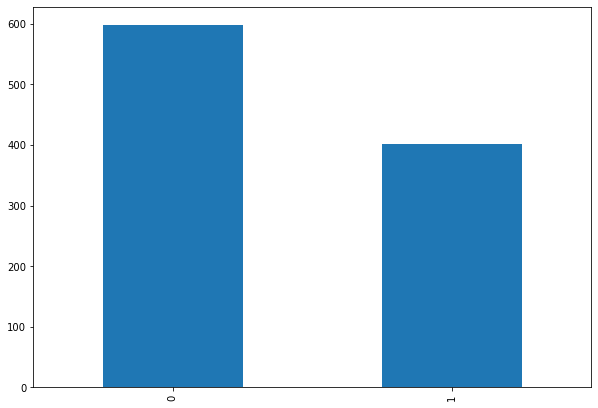

In [4]:
df.personal_status_sex.value_counts().plot(kind="bar")

<AxesSubplot:>

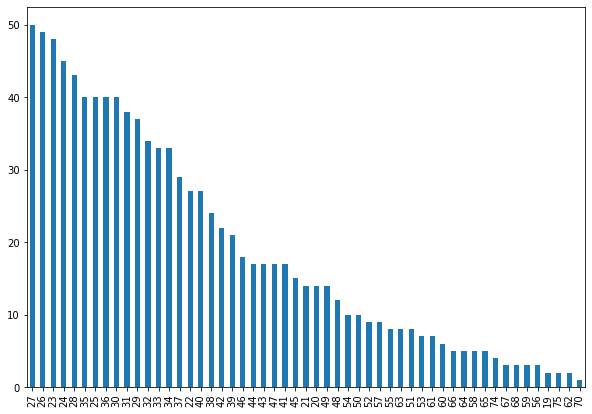

In [5]:
df.age.value_counts().plot(kind="bar")

In [6]:
binary_cols = []
non_binary_cols = []
for col in df.columns:
    nunique = df[col].nunique()
    if nunique == 2:
        binary_cols.append(col)
    else:
        non_binary_cols.append(col)

In [7]:
non_binary_cols, len(binary_cols)

(['duration', 'amount', 'age'], 63)

In [8]:
df[non_binary_cols].describe()

,duration,amount,age
count,1000.000000,1000.00000,1000.00000
mean,20.903000,3271.24800,35.54200
std,12.058814,2822.75176,11.35267
min,4.000000,250.00000,19.00000
25%,12.000000,1365.50000,27.00000
50%,18.000000,2319.50000,33.00000
75%,24.000000,3972.25000,42.00000
max,72.000000,18424.00000,75.00000


duration


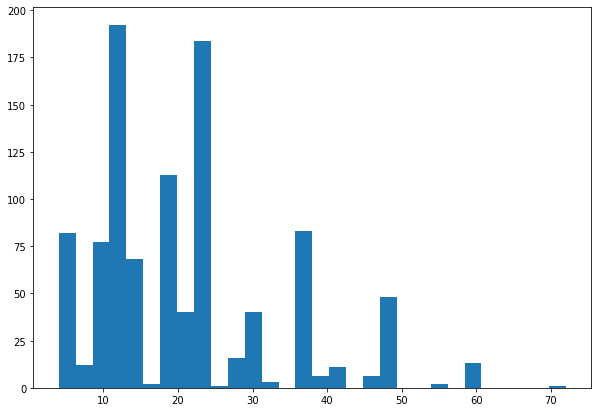

amount


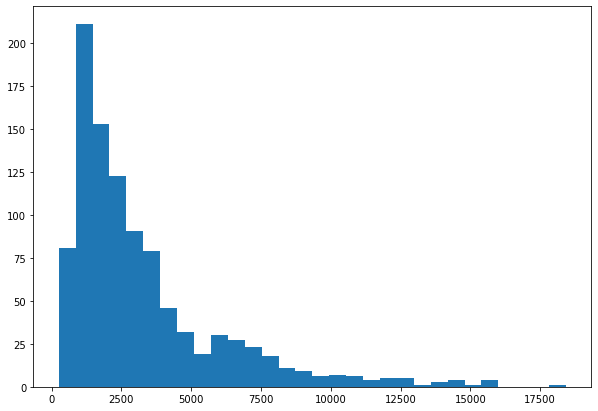

age


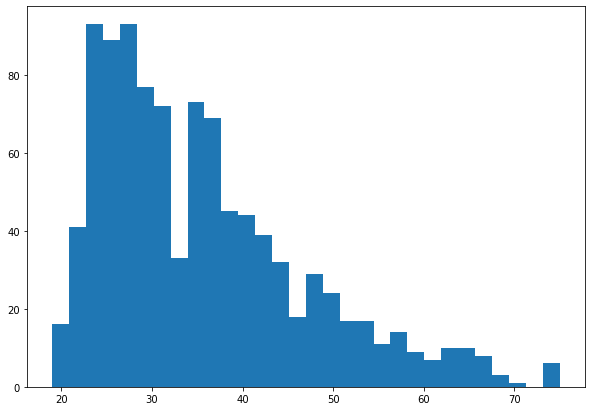

In [9]:
for col in non_binary_cols:
    print(col)
    plt.hist(df[col], bins=30)
    plt.show()

In [10]:
binary_cols

['status_no checking account',
 'status_... < 0 DM',
 'status_0<= ... < 200 DM',
 'status_... >= 200 DM / salary for at least 1 year',
 'credit_history_delay in paying off in the past',
 'credit_history_critical account/other credits elsewhere',
 'credit_history_no credits taken/all credits paid back duly',
 'credit_history_existing credits paid back duly till now',
 'credit_history_all credits at this bank paid back duly',
 'purpose_others',
 'purpose_car (new)',
 'purpose_car (used)',
 'purpose_furniture/equipment',
 'purpose_radio/television',
 'purpose_domestic appliances',
 'purpose_repairs',
 'purpose_vacation',
 'purpose_retraining',
 'purpose_business',
 'savings_unknown/no savings account',
 'savings_... <  100 DM',
 'savings_100 <= ... <  500 DM',
 'savings_500 <= ... < 1000 DM',
 'savings_... >= 1000 DM',
 'employment_duration_unemployed',
 'employment_duration_< 1 yr',
 'employment_duration_1 <= ... < 4 yrs',
 'employment_duration_4 <= ... < 7 yrs',
 'employment_duration_>=

# Task 1. 
Train a binary classifier to predict credit_risk on the raw dataset and
calculate its general accuracy, and respectively the accuracies for men
and women and for people aged ≤35 and >35. The model does not need
to be fancy, logistic regression or Random Forest are completely fine
choices. Remember to evaluate the model using cross validation.

<AxesSubplot:>

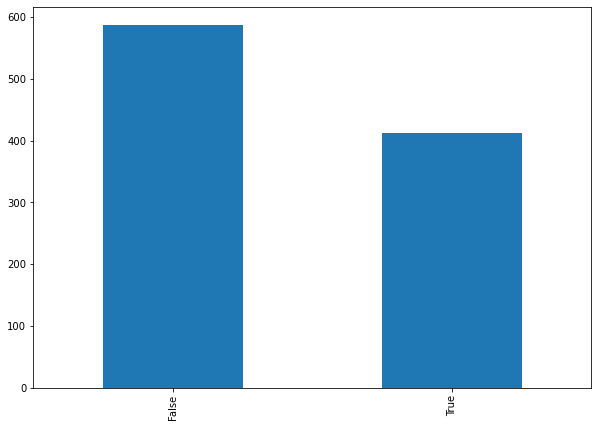

In [11]:
# Create variable to indicate if a person is older than 35
df["above_35"] = df.age.apply(lambda x: x > 35)
df.above_35.value_counts().plot(kind="bar")

In [12]:
df.credit_risk.value_counts()

1    700
0    300
Name: credit_risk, dtype: int64

**Note** as the the credit risk are skewed, we will be using stratified cross validation

In [13]:
def scale_data():
    def call(X_train, X_test):
        # Standard scale the data data
        _mean = np.mean(X_train, axis=0)
        _std = np.std(X_train, ddof=1, axis=0)
        X_train_scaled = (X_train - _mean)/_std
        X_test_scaled = (X_test - _mean)/_std
        return X_train_scaled, X_test_scaled
    return call

In [14]:
def test_model(model, X, y, kfold, process_data=None, seed=1):
    """
    Test models using some cross validation method and with a scaling method.
    
    Parameters
    ----------
    model : sklearn model object. 
        This object must not be instansiated

    X : pandas.Dataframe
        df containing all the features, which the model should be trained on
        
    y : np.array
        An array on the taget values
    
    kfold : sklearn.model_selection method e.g. KFold
        This object must not be initialised. See example
        
    process_data : Function, default=None
        Data processing pipeline of the form (X_train, X_test) => X_train_processed, X_test_processed
        If None, then are the data not processed
        
        
    Returns
    -------
    numpy.array
        An array containing the predictions


    Example
    -------
    X, y = df.drop(columns=['credit_risk']), df['credit_risk'].values
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    process_data = scale_data()
    model = LogisticRegression
    preds = test_model(model, X, y, kfold, process_data)
    """
    
    preds = np.zeros(len(y))
    
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if process_data:
            X_train, X_test = process_data(X_train, X_test)
            
        tmp_model = model(random_state=seed)
        tmp_model = tmp_model.fit(X_train, y_train)
        preds[test_index] = tmp_model.predict(X_test)    
    return preds
    
X, y = df.drop(columns=['credit_risk', "above_35"]), df['credit_risk'].values
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
process_data = scale_data()
model = LogisticRegression
preds = test_model(model, X, y, kfold, process_data)

In [15]:
results_df = df.copy()
results_df["task_1_preds"] = preds

Overall accuracy = 0.751
Male accuracy = 0.773
Female accuracy = 0.741
Above 35 accuracy = 0.806
35 or less accuracy = 0.726


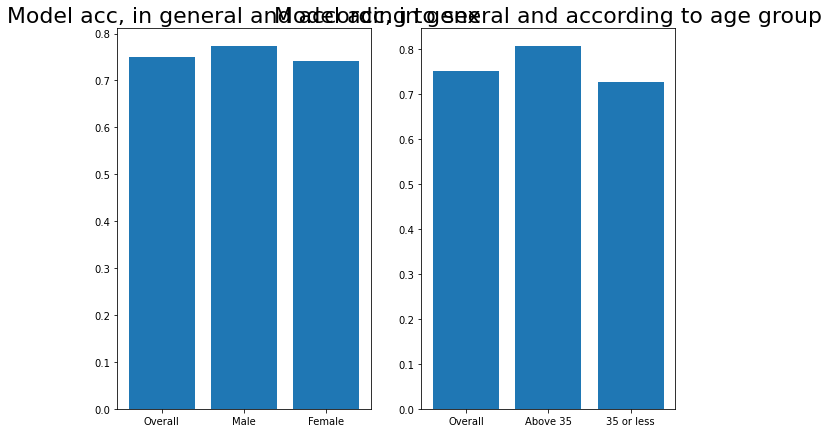

In [16]:
# Report accuracies
def report_results(result_df, result_col):
    """
    Report the accuracies from an experience
    
    Parameters
    ----------
    result_df : pandas.DataFrame
        The original df containing all of the credit card features and the credit_risk
        and with the the predictions from the experiment.

    result_col : Str
        Name of the column containing the prediction from the experiment
        
        
    Returns
    -------
    None


    Example
    -------
    results_df = df.copy()
    results_df["task_1_preds"] = preds
    result_col = "task_1_preds"
    report_results(results_df, result_col)
    """
    y_true = result_df["credit_risk"].values
    y_pred = result_df[result_col].values
    acc = accuracy_score(y_true, y_pred)
    print(f"Overall accuracy = {acc:.3}")
    
    male_idx = result_df.loc[result_df.personal_status_sex == 0].index.values
    male_acc = accuracy_score(y_true[male_idx], y_pred[male_idx])
    female_acc = accuracy_score(y_true[~male_idx], y_pred[~male_idx])
    print(f"Male accuracy = {male_acc:.3}")
    print(f"Female accuracy = {female_acc:.3}")
    
    
    above35_idx = result_df.loc[result_df.above_35].index.values
    above35_acc = accuracy_score(y_true[above35_idx], y_pred[above35_idx])
    not_above35_acc = accuracy_score(y_true[~above35_idx], y_pred[~above35_idx])
    print(f"Above 35 accuracy = {above35_acc:.3}")
    print(f"35 or less accuracy = {not_above35_acc:.3}")
    
    fig, axs = plt.subplots(1, 2)
    
    axs[0].bar(["Overall", "Male", "Female"], [acc, male_acc, female_acc])
    axs[0].set_title("Model acc, in general and according to sex")    
    
    axs[1].bar(["Overall", "Above 35", "35 or less"], [acc, above35_acc, not_above35_acc])
    axs[1].set_title("Model acc, in general and according to age group")
    plt.show()

result_col = "task_1_preds"
report_results(results_df, result_col)

# Task 2.
Using the “fairer” (reprojected) version of the dataset, build a similar
classification model and calculate: 
1) the overall accuracy, 

2) the accuracy for men and women, and 

3) for people aged ≤35 and >35. 

Record your results and create a plot of how accuracies vary as functions of �Î[0,1].

In [17]:
from scipy.stats import pearsonr
import scipy

In [18]:
def reproject_features(data, protected_cols, nonprotected_cols):
    """
    generate a fair representation of nonprotected columns which are independent from any columns in protected_cols
    dat_: a data frame
    protected_cols: list of strings, the protected columns
    nonprotected_col: string, all other data columns 
    
    NOTE: this function assumes the data is already centered 
    """
    # make a copy of data
    df = data.copy()
    # Protected features
    protect = df[protected_cols].values
    # extract data about nonprotected columns
    debiased_nonprotect = df[nonprotected_cols].values
    # crease an orthonormal basis
    base_protect = scipy.linalg.orth(protect)
    for j in range(debiased_nonprotect.shape[1]):
        debiased_nonprotect[:,j] -= base_protect @ base_protect.T @ debiased_nonprotect[:,j]
    return debiased_nonprotect

def reproject_features_w_regul(data, protected_cols, nonprotected_cols, lambda_):
    """
    generate a fair representation of nonprotected columns which are independent from any columns in protected_cols
    dat_: a data frame
    protected_cols: list of strings, the protected columns
    nonprotected_col: string, all other data columns 
    lambda_: float number between 0 and 1, 0 means totally fair; 1 means same as raw data
    """
    
    # run the normal reproject_features function
    r = reproject_features(data, protected_cols, nonprotected_cols)
    
    # extract data about nonprotected variables
    nonprotect = data[nonprotected_cols].values
    # standardize columns

    return r + lambda_*(nonprotect - r)

In [19]:
def debais_data(protected_cols, nonprotected_cols, lambda_=0):
    """
    Debias data, data pipeline
    
    Arguments
    ---------
    protected_cols: list of strings, 
        the protected columns
    
    nonprotected_col: String, 
        all other data columns 
    
    Returns
    -------
    Function(X_train, X_test) => X_train_r, X_test_r
        A fucntion which takes X_train, X_test and returns the reprojected versions of X_train, X_test
    
    """
    def call(X_train, X_test):
        # Standard scale the data data
        _mean = np.mean(X_train, axis=0)
        _std = np.std(X_train, ddof=1, axis=0)
        X_train_scaled = (X_train - _mean)/_std
        X_test_scaled = (X_test - _mean)/_std
        # reproject features
        X_train_r = reproject_features_w_regul(X_train_scaled, protected_cols, nonprotected_cols, lambda_)
        X_test_r = reproject_features_w_regul(X_test_scaled, protected_cols, nonprotected_cols, lambda_)
        return X_train_r, X_test_r
    return call

In [20]:
protected_cols = ["personal_status_sex", "age"]
nonprotected_cols = [col for col in X.columns if col not in protected_cols]

In [21]:
def get_accuracies(y_true, y_pred, X):
    """
    Get the accuracies for males, females, above 35 years and 35 or less years old samples
    """
    
    male_idx = X.loc[X.personal_status_sex == 0].index.values
    male_acc = accuracy_score(y_true[male_idx], y_pred[male_idx])
    female_acc = accuracy_score(y_true[~male_idx], y_pred[~male_idx])
    
    above35_idx = X.loc[X.age > 35].index.values
    above35_acc = accuracy_score(y_true[above35_idx], y_pred[above35_idx])
    not_above35_acc = accuracy_score(y_true[~above35_idx], y_pred[~above35_idx])
    return male_acc, female_acc, above35_acc, not_above35_acc

In [22]:
num_experiments = 10
lambdas = [0.0,0.25,0.5,0.75,1.]
aggregated_accs = [0]*(len(lambdas)+1)
aggregated_male = [0]*(len(lambdas)+1)
aggregated_female = [0]*(len(lambdas)+1)
aggregated_a35 = [0]*(len(lambdas)+1)
aggregated_na35 = [0]*(len(lambdas)+1)

X, y = df.drop(columns=['credit_risk', "above_35"]), df['credit_risk'].values
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Test each value of lambda 10 times with 10 fold cross validation
for i in range(len(lambdas)):
    experiments_accs = [0]*num_experiments
    experiments_m = [0]*num_experiments
    experiments_f = [0]*num_experiments
    experiments_a35 = [0]*num_experiments
    experiments_na35 = [0]*num_experiments
    for j in range(num_experiments):
        model = LogisticRegression
        _X = X.copy()
        process_data = debais_data(protected_cols, nonprotected_cols, lambda_=lambdas[i])
        _preds = test_model(model, _X, y, kfold, process_data, seed=j*i)
        experiments_accs[j] = accuracy_score(y, _preds)
        male_acc, female_acc, above35_acc, not_above35_acc = get_accuracies(y, _preds, X)
        experiments_m[j] = male_acc
        experiments_f[j] = female_acc
        experiments_a35[j] = above35_acc
        experiments_na35[j] = not_above35_acc
    aggregated_accs[i] = np.mean(experiments_accs)
    aggregated_male[i] = np.mean(experiments_m)
    aggregated_female[i] = np.mean(experiments_f)
    aggregated_a35[i] = np.mean(experiments_a35)
    aggregated_na35[i] = np.mean(experiments_na35)

# regular data
experiments_accs = [0]*num_experiments
experiments_m = [0]*num_experiments
experiments_f = [0]*num_experiments
experiments_a35 = [0]*num_experiments
experiments_na35 = [0]*num_experiments
for j in range(num_experiments):
    model = LogisticRegression
    process_data = scale_data()
    _preds = test_model(model, X, y, kfold, process_data)
    experiments_accs[j] = accuracy_score(y, _preds)
    male_acc, female_acc, above35_acc, not_above35_acc = get_accuracies(y, _preds, X)
    experiments_m[j] = male_acc
    experiments_f[j] = female_acc
    experiments_a35[j] = above35_acc
    experiments_na35[j] = not_above35_acc
aggregated_accs[-1] = np.mean(experiments_accs)
aggregated_male[-1] = np.mean(experiments_m)
aggregated_female[-1] = np.mean(experiments_f)
aggregated_a35[-1] = np.mean(experiments_a35)
aggregated_na35[-1] = np.mean(experiments_na35)


In [23]:
experiments_labels = [f"L:{x}" for x in lambdas]

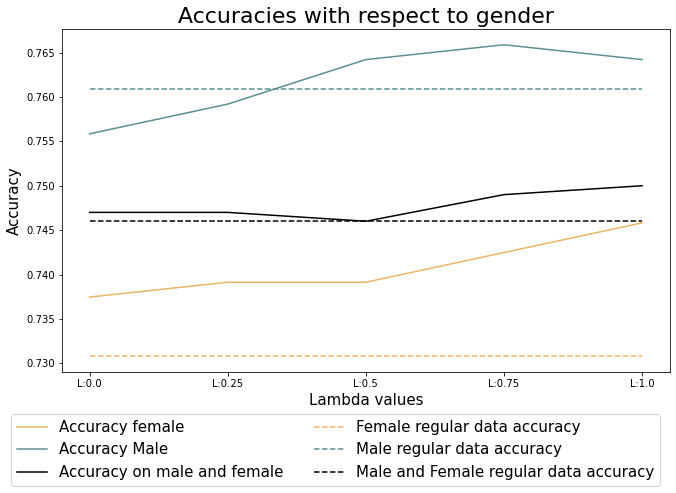

In [24]:
b = "#E9B666"
g = "#5C9090"
plt.plot(aggregated_female[:-1], label="Accuracy female", c=b)
plt.hlines(y=aggregated_female[-1], xmin=0, xmax=4, colors=b, linestyle="--", label="Female regular data accuracy")

plt.plot(aggregated_male[:-1], label="Accuracy Male", c=g)
plt.hlines(y=aggregated_male[-1], xmin=0, xmax=4, colors=g, linestyle="--", label="Male regular data accuracy")

plt.plot(aggregated_accs[:-1], label="Accuracy on male and female", c="black")
plt.hlines(y=aggregated_accs[-1], xmin=0, xmax=4, label="Male and Female regular data accuracy", colors="black", linestyle="--")

plt.xticks(ticks=list(range(len(experiments_labels))), labels=experiments_labels)

plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("Lambda values", fontsize=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.45, -0.1),
          fancybox=True, ncol=2, fontsize=15)
plt.title("Accuracies with respect to gender")
plt.tight_layout()
plt.savefig("figs/accuracies_sex.png")
plt.show()

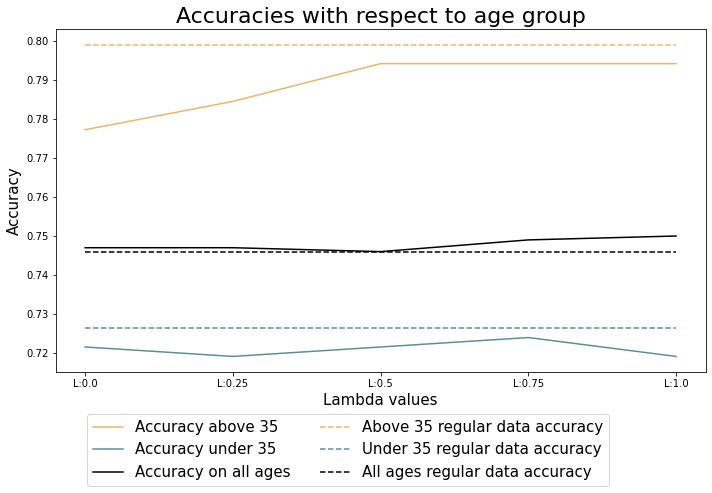

In [25]:
b = "#E9B666"
g = "#5C9090"
plt.plot(aggregated_a35[:-1], label="Accuracy above 35", c=b)
plt.hlines(y=aggregated_a35[-1], xmin=0, xmax=4, colors=b, linestyle="--", label="Above 35 regular data accuracy")

plt.plot(aggregated_na35[:-1], label="Accuracy under 35", c=g)
plt.hlines(y=aggregated_na35[-1], xmin=0, xmax=4, colors=g, linestyle="--", label="Under 35 regular data accuracy")

plt.plot(aggregated_accs[:-1], label="Accuracy on all ages", c="black")
plt.hlines(y=aggregated_accs[-1], xmin=0, xmax=4, label="All ages regular data accuracy", colors="black", linestyle="--")

plt.xticks(ticks=list(range(len(experiments_labels))), labels=experiments_labels)

plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("Lambda values", fontsize=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.45, -0.1),
          fancybox=True, ncol=2, fontsize=15)
plt.title("Accuracies with respect to age group")
plt.tight_layout()
plt.savefig("figs/accuracies_age.png")

plt.show()

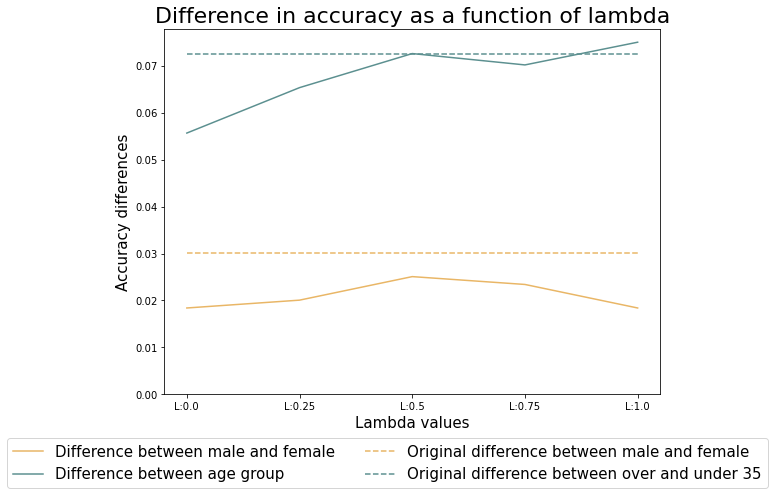

In [26]:
b = "#E9B666"
g = "#5C9090"
plt.plot(np.array(aggregated_male[:-1]) - np.array(aggregated_female[:-1]), label="Difference between male and female", c=b)
plt.plot(np.array(aggregated_a35[:-1]) - np.array(aggregated_na35[:-1]), label="Difference between age group", c=g)

plt.ylim(bottom=0)
plt.xticks(ticks=list(range(len(experiments_labels))), labels=experiments_labels)

plt.hlines(y=aggregated_male[-1] - aggregated_female[-1], xmin=0, xmax=4, colors=b, linestyle="--", label="Original difference between male and female")
plt.hlines(y=aggregated_a35[-1] - aggregated_na35[-1], xmin=0, xmax=4, colors=g, linestyle="--", label="Original difference between over and under 35")


plt.ylabel("Accuracy differences", fontsize=15)
plt.xlabel("Lambda values", fontsize=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.45, -0.1),
          fancybox=True, ncol=2, fontsize=15)
plt.title("Difference in accuracy as a function of lambda")
plt.tight_layout()
plt.savefig("figs/accuracies_diff.png")

plt.show()

## The normal data correlations

In [27]:
protected_cols = ["age", "personal_status_sex"]
nonprotected_cols = [col for col in X.columns if col not in protected_cols + ["above_35"]]

In [28]:
dat = X.copy()
dat = dat[[col for col in nonprotected_cols]+protected_cols]

In [29]:
# start by calculating correlation in the dataset
corr_dat = np.ones((X.shape[1],X.shape[1]))
p_values = np.zeros((X.shape[1],X.shape[1]))

# go through all features
features = dat.keys()
for feature_i in range(len(features)):
    for feature_j in range(feature_i,len(features)):
        if feature_i != feature_j:
            
            fi = features[feature_i]
            fj = features[feature_j]
            
            # calculate correlation
            r,p = pearsonr(dat[fi],dat[fj])
            
            # save correlation values
            corr_dat[feature_i,feature_j] = r
            # because correlation is symmetric we also fill in the other value
            corr_dat[feature_j,feature_i] = r
            
            # save p-values
            p_values[feature_i,feature_j] = p
            # because correlation is symmetric we also fill in the other value
            p_values[feature_j,feature_i] = p

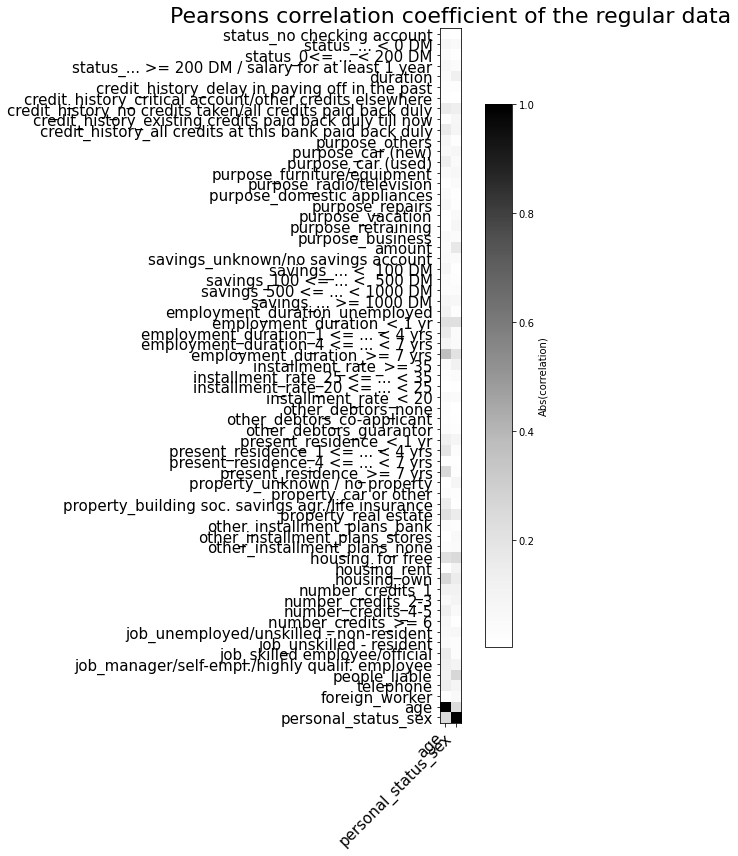

In [30]:
plt.figure(figsize=(9,12))
plt.imshow(abs(corr_dat[:,-2:]),cmap=plt.cm.Greys,zorder=2)
plt.xticks(range(2),features[-2:],fontsize=15,rotation=45,ha='right')
plt.yticks(range(len(features)),features,fontsize=15,rotation=0,ha='right')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Abs(correlation)')
#plt.tight_layout()
plt.title("Pearsons correlation coefficient of the regular data")
plt.tight_layout()
plt.savefig("figs/correlation_pearson_before.png")
plt.show()

In [31]:
corrected_p_value = 0.05 / (len(features)**2/2)
# createa a binary p-value-matrix
corrected_p_matrix = np.ones(p_values.shape)
# threshold it to significatng and non-significant
corrected_p_matrix[p_values >= corrected_p_value] = 0

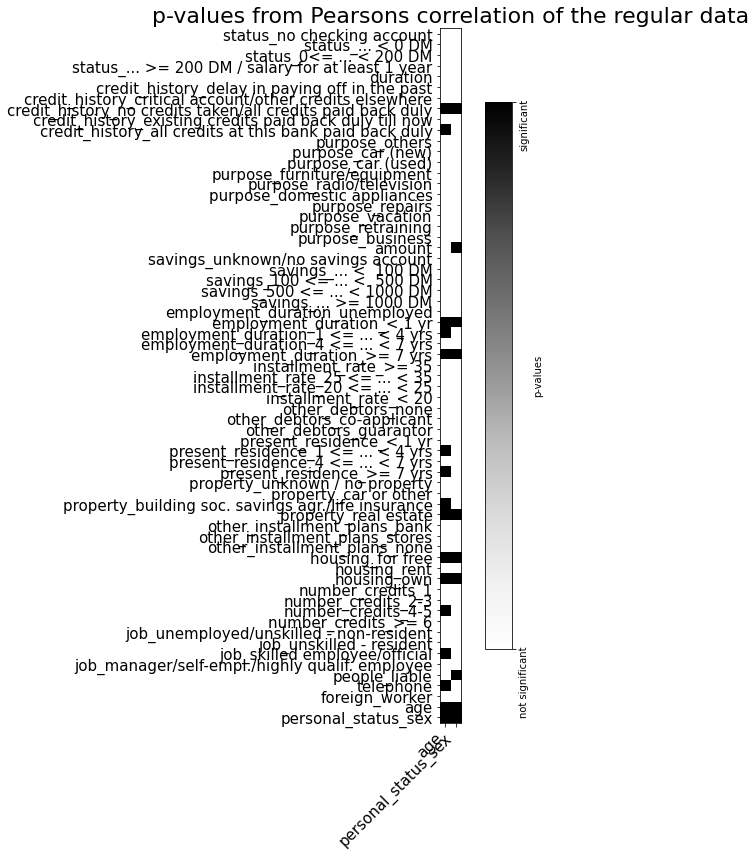

In [32]:
plt.figure(figsize=(9,12))
#plt.imshow(p_values,cmap=plt.cm.greys)
plt.imshow(corrected_p_matrix[:,-2:],cmap=plt.cm.Greys,zorder=2)
plt.xticks(range(2),features[-2:],fontsize=15,rotation=45,ha='right')
plt.yticks(range(len(features)),features,fontsize=15,rotation=0,ha='right')
cbar = plt.colorbar(ticks=[0, 1],fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['not significant','significant'],rotation=90)
cbar.set_label('p-values')
plt.title("p-values from Pearsons correlation of the regular data")

plt.tight_layout()
plt.savefig("figs/correlation_pearson_before_pvals.png")

plt.show()

# Spearman before transformation

In [33]:
from scipy.stats import spearmanr

In [34]:
protected_cols = ["age", "personal_status_sex"]
nonprotected_cols = [col for col in X.columns if col not in protected_cols + ["above_35"]]

In [35]:
dat = X.copy()
dat = dat[[col for col in nonprotected_cols]+protected_cols]

In [36]:
# start by calculating correlation in the dataset
corr_dat = np.ones((X.shape[1],X.shape[1]))
p_values = np.zeros((X.shape[1],X.shape[1]))

# go through all features
features = dat.keys()
for feature_i in range(len(features)):
    for feature_j in range(feature_i,len(features)):
        if feature_i != feature_j:
            
            fi = features[feature_i]
            fj = features[feature_j]
            
            # calculate correlation
            r,p = spearmanr(dat[fi],dat[fj])
            
            # save correlation values
            corr_dat[feature_i,feature_j] = r
            # because correlation is symmetric we also fill in the other value
            corr_dat[feature_j,feature_i] = r
            
            # save p-values
            p_values[feature_i,feature_j] = p
            # because correlation is symmetric we also fill in the other value
            p_values[feature_j,feature_i] = p

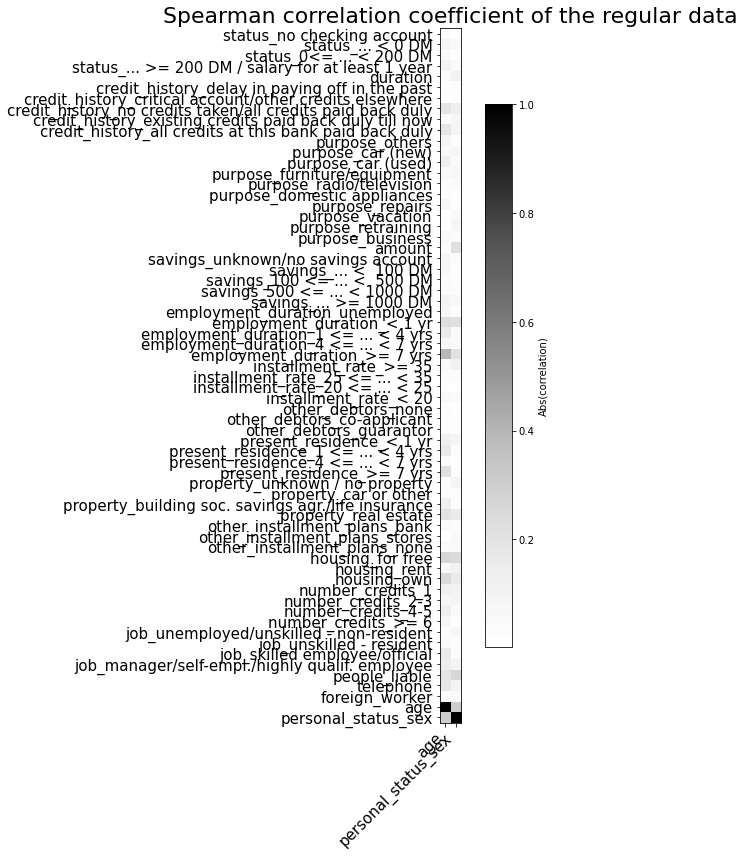

In [37]:
plt.figure(figsize=(9,12))
plt.imshow(abs(corr_dat[:,-2:]),cmap=plt.cm.Greys,zorder=2)
plt.xticks(range(2),features[-2:],fontsize=15,rotation=45,ha='right')
plt.yticks(range(len(features)),features,fontsize=15,rotation=0,ha='right')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Abs(correlation)')
plt.title("Spearman correlation coefficient of the regular data")

plt.tight_layout()
plt.savefig("figs/correlation_spearman_before.png")

plt.show()

In [38]:
corrected_p_value = 0.05 / (len(features)**2/2)
# createa a binary p-value-matrix
corrected_p_matrix = np.ones(p_values.shape)
# threshold it to significatng and non-significant
corrected_p_matrix[p_values >= corrected_p_value] = 0

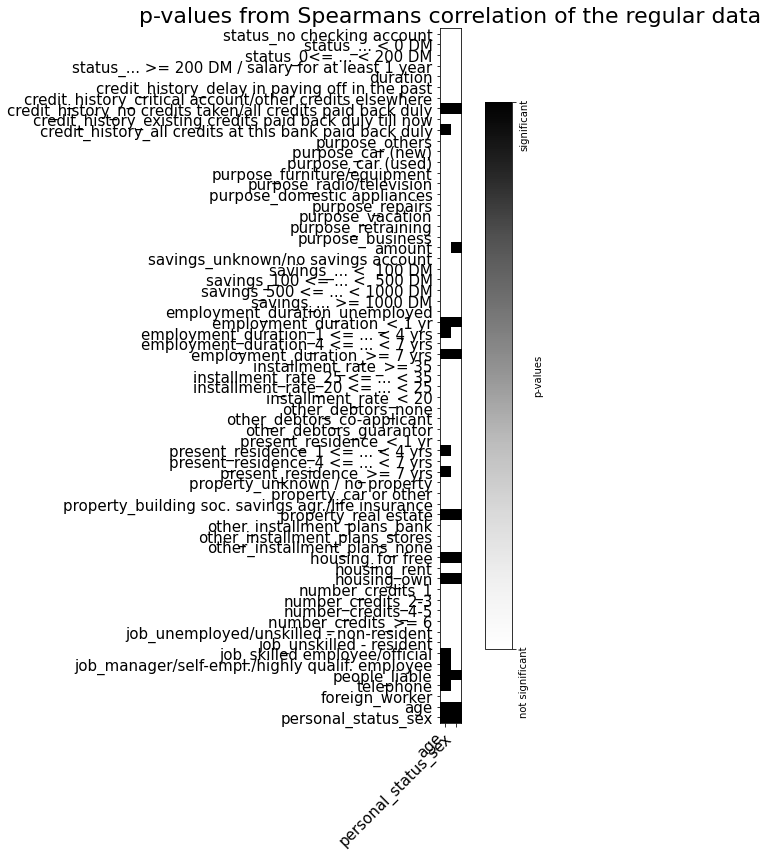

In [39]:
plt.figure(figsize=(9,12))
#plt.imshow(p_values,cmap=plt.cm.greys)
plt.imshow(corrected_p_matrix[:,-2:],cmap=plt.cm.Greys,zorder=2)
plt.xticks(range(2),features[-2:],fontsize=15,rotation=45,ha='right')
plt.yticks(range(len(features)),features,fontsize=15,rotation=0,ha='right')
cbar = plt.colorbar(ticks=[0, 1],fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['not significant','significant'],rotation=90)
cbar.set_label('p-values')
plt.title("p-values from Spearmans correlation of the regular data")

plt.tight_layout()
plt.savefig("figs/correlation_spearman_before_pvals.png")

plt.show()

# "Debiasing" the data

In [40]:
process_data = debais_data(protected_cols, nonprotected_cols)

In [41]:
X_r, _ = process_data(X,X)

In [42]:
X_r = pd.DataFrame(X_r, columns=nonprotected_cols)

In [43]:
X_r["personal_status_sex"] = ((X.personal_status_sex - X.personal_status_sex.mean()) / X.personal_status_sex.std())
X_r["age"] = ((X.age - X.age.mean()) / X.age.std())

dat = X_r.copy()

In [44]:
# start by calculating correlation in the dataset
corr_dat = np.ones((X_r.shape[1],X_r.shape[1]))
p_values = np.zeros((X_r.shape[1],X_r.shape[1]))

# go through all features
features = X_r.keys()
for feature_i in range(len(features)):
    for feature_j in range(feature_i,len(features)):
        if feature_i != feature_j:
            
            fi = features[feature_i]
            fj = features[feature_j]
            
            # calculate correlation
            r,p = pearsonr(dat[fi],dat[fj])
            
            # save correlation values
            corr_dat[feature_i,feature_j] = r
            # because correlation is symmetric we also fill in the other value
            corr_dat[feature_j,feature_i] = r
            
            # save p-values
            p_values[feature_i,feature_j] = p
            # because correlation is symmetric we also fill in the other value
            p_values[feature_j,feature_i] = p

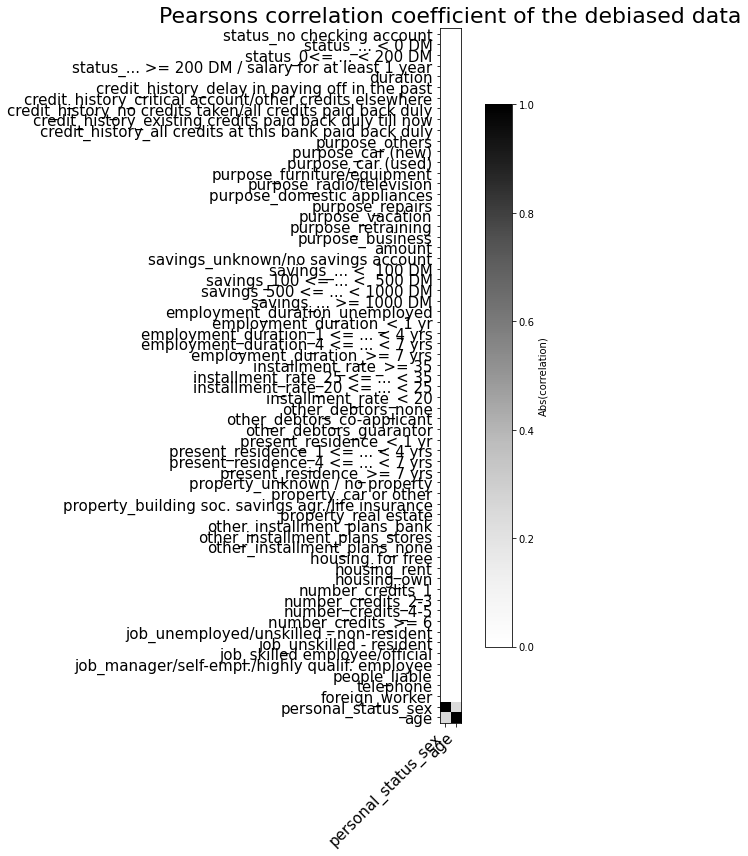

In [45]:
plt.figure(figsize=(9,12))
plt.imshow(abs(corr_dat[:,-2:]),cmap=plt.cm.Greys,zorder=2)
plt.xticks(range(2),features[-2:],fontsize=15,rotation=45,ha='right')
plt.yticks(range(len(features)),features,fontsize=15,rotation=0,ha='right')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Abs(correlation)')
plt.title("Pearsons correlation coefficient of the debiased data")

plt.tight_layout()
plt.savefig("figs/correlation_pearson_after.png")

plt.show()

In [46]:
corrected_p_value = 0.05 / (len(features)**2/2)
# createa a binary p-value-matrix
corrected_p_matrix = np.ones(p_values.shape)
# threshold it to significatng and non-significant
corrected_p_matrix[p_values >= corrected_p_value] = 0

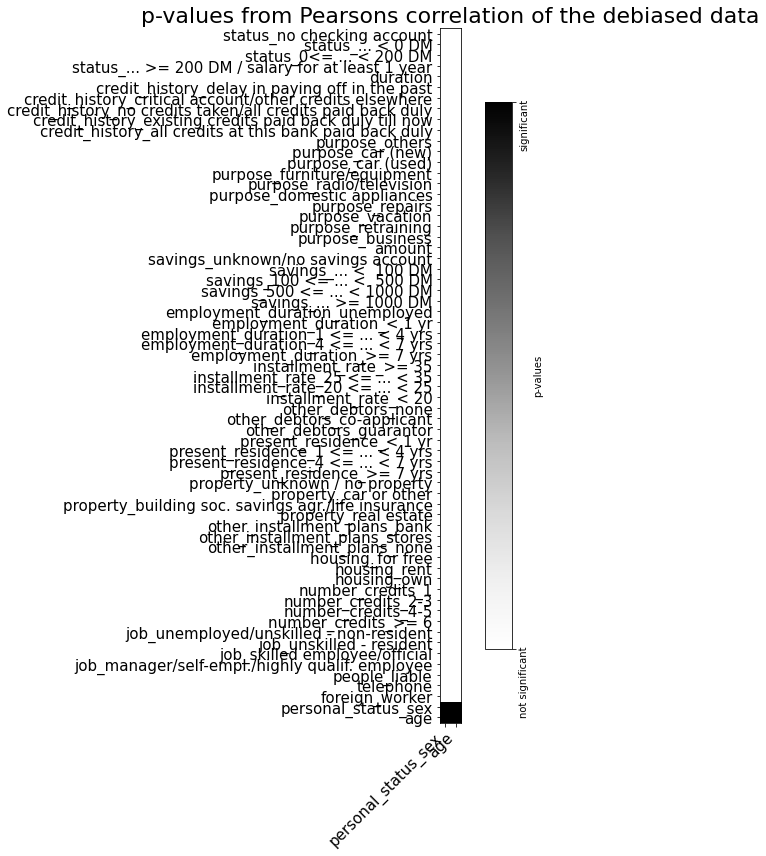

In [47]:
plt.figure(figsize=(9,12))
#plt.imshow(p_values,cmap=plt.cm.greys)
plt.imshow(corrected_p_matrix[:,-2:],cmap=plt.cm.Greys,zorder=2)
plt.xticks(range(2),features[-2:],fontsize=15,rotation=45,ha='right')
plt.yticks(range(len(features)),features,fontsize=15,rotation=0,ha='right')
cbar = plt.colorbar(ticks=[0, 1],fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['not significant','significant'],rotation=90)
cbar.set_label('p-values')
plt.title("p-values from Pearsons correlation of the debiased data")

plt.tight_layout()
plt.savefig("figs/correlation_pearson_after_pvals.png")

plt.show()

# Spearman correlation

In [48]:
from scipy.stats import spearmanr

In [49]:
process_data = debais_data(protected_cols, nonprotected_cols)

In [50]:
X_r, _ = process_data(X,X)

In [51]:
X_r = pd.DataFrame(X_r, columns=nonprotected_cols)

In [52]:
X_r["personal_status_sex"] = ((X.personal_status_sex - X.personal_status_sex.mean()) / X.personal_status_sex.std())
X_r["age"] = ((X.age - X.age.mean()) / X.age.std())

dat = X_r.copy()

In [53]:
# start by calculating correlation in the dataset
corr_dat = np.ones((X_r.shape[1],X_r.shape[1]))
p_values = np.zeros((X_r.shape[1],X_r.shape[1]))

# go through all features
features = X_r.keys()
for feature_i in range(len(features)):
    for feature_j in range(feature_i,len(features)):
        if feature_i != feature_j:
            
            fi = features[feature_i]
            fj = features[feature_j]
            
            # calculate correlation
            r,p = spearmanr(dat[fi],dat[fj])
            
            # save correlation values
            corr_dat[feature_i,feature_j] = r
            # because correlation is symmetric we also fill in the other value
            corr_dat[feature_j,feature_i] = r
            
            # save p-values
            p_values[feature_i,feature_j] = p
            # because correlation is symmetric we also fill in the other value
            p_values[feature_j,feature_i] = p

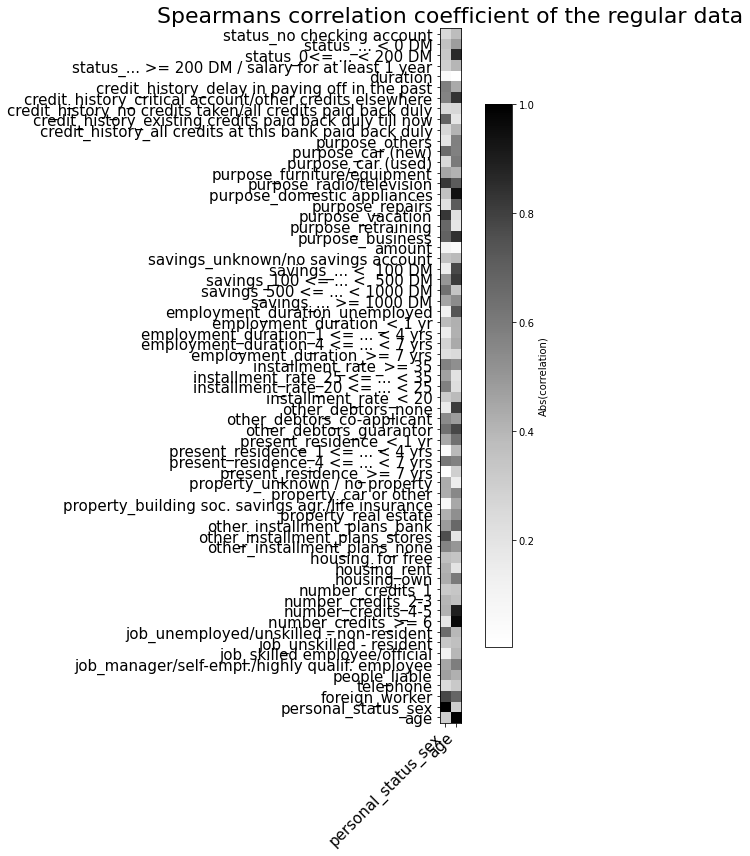

In [54]:
plt.figure(figsize=(9,12))
plt.imshow(abs(corr_dat[:,-2:]),cmap=plt.cm.Greys,zorder=2)
plt.xticks(range(2),features[-2:],fontsize=15,rotation=45,ha='right')
plt.yticks(range(len(features)),features,fontsize=15,rotation=0,ha='right')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Abs(correlation)')
plt.title("Spearmans correlation coefficient of the regular data")

plt.tight_layout()
plt.savefig("figs/correlation_spearman_after.png")

plt.show()

In [55]:
corrected_p_value = 0.05 / (len(features)**2/2)
# createa a binary p-value-matrix
corrected_p_matrix = np.ones(p_values.shape)
# threshold it to significatng and non-significant
corrected_p_matrix[p_values >= corrected_p_value] = 0

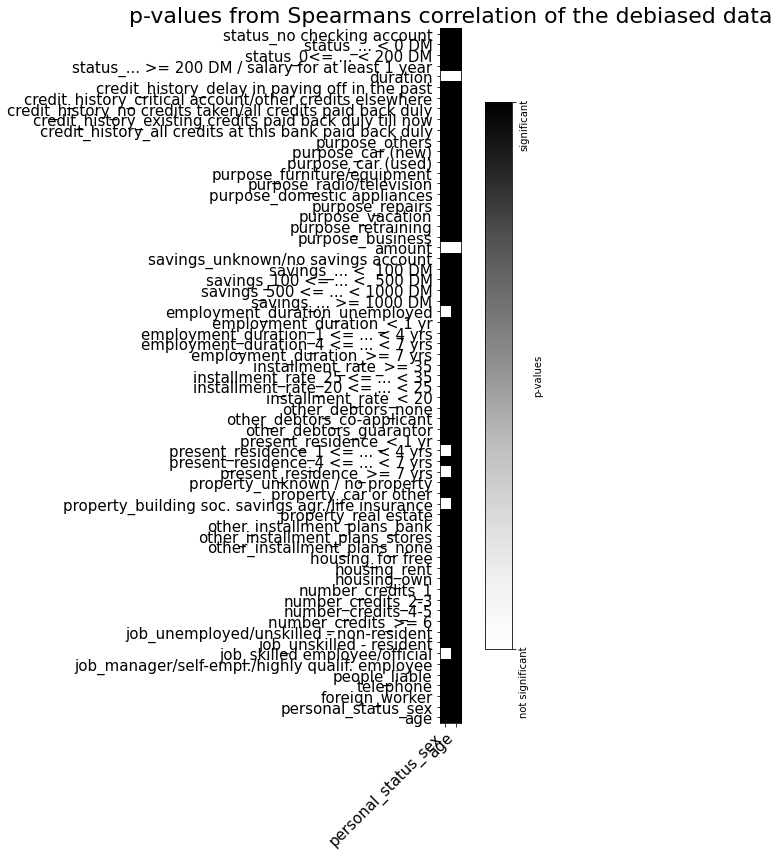

In [56]:
plt.figure(figsize=(9,12))
#plt.imshow(p_values,cmap=plt.cm.greys)
plt.imshow(corrected_p_matrix[:,-2:],cmap=plt.cm.Greys,zorder=2)
plt.xticks(range(2),features[-2:],fontsize=15,rotation=45,ha='right')
plt.yticks(range(len(features)),features,fontsize=15,rotation=0,ha='right')
cbar = plt.colorbar(ticks=[0, 1],fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['not significant','significant'],rotation=90)
cbar.set_label('p-values')
plt.title("p-values from Spearmans correlation of the debiased data")
plt.savefig("figs/correlation_spearman_after_pvals.png")

plt.tight_layout()
plt.show()